In [3]:
%pip install PyniteFEA[all]
%pip install Pynite
%pip install trimesh

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Spacing: 12.0' x 12.0', Columns: 24, Max Deflection: 3.6000'
Spacing: 12.0' x 14.0', Columns: 18, Max Deflection: 3.6000'
Spacing: 12.0' x 16.0', Columns: 18, Max Deflection: 3.6000'
Spacing: 12.0' x 18.0', Columns: 18, Max Deflection: 3.6000'
Spacing: 12.0' x 20.0', Columns: 18, Max Deflection: 3.6000'
Spacing: 14.0' x 12.0', Columns: 20, Max Deflection: 3.6000'
Spacing: 14.0' x 14.0', Columns: 15, Max Deflection: 3.6000'
Spacing: 14.0' x 16.0', Columns: 15, Max Deflection: 3.6000'
Spacing: 14.0' x 18.0', Columns: 15, Max Deflection: 3.6000'
Spacing: 14.0' x 20.0', Columns: 15, Max Deflection: 3.6000'
Spacing: 16.0' x 12.0', Columns: 16, Max Deflection: 3.6000'
Spacing: 16.0' x 14.0', Columns: 12, Max Deflection: 3.6000'
Spacing: 16.0' x 16.0', Columns: 12, Max Deflection: 3.6000'
Spacing: 16.0' x 18.0', Columns: 12, Max Deflection: 3.6000'
Spacing: 16.0' x 20.0', Columns: 12, Max Deflection: 3.6000'
Spacing: 18.0' x 12.0', Columns: 16, Max Deflection: 3.6000'
Spacing: 18.0' x 14.0', 

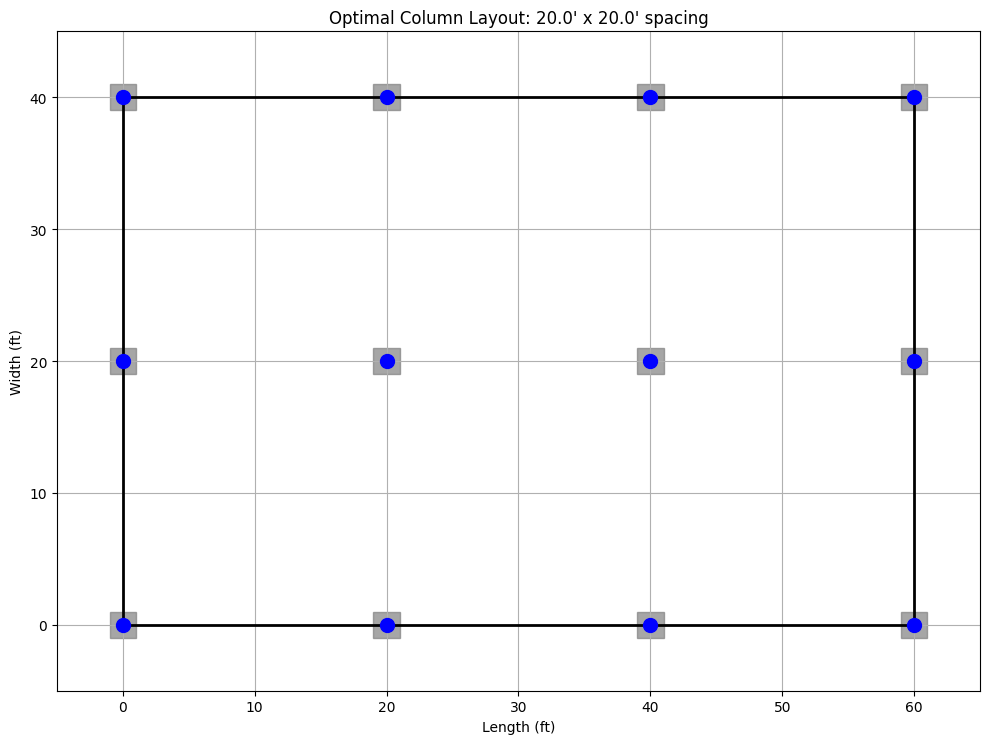

In [6]:
from Pynite.FEModel3D import FEModel3D
import numpy as np
import matplotlib.pyplot as plt

def create_column_grid(model, length, width, height, x_spacing, y_spacing):
    """Create a grid of columns with the specified spacing"""
    # Clear existing nodes and members
    for node_name in list(model.nodes.keys()):
        if node_name.startswith('C'):  # Column nodes
            model.delete_node(node_name)
    
    # Create column grid
    node_counter = 1
    member_counter = 1
    columns = []
    
    # Generate bottom nodes for columns
    bottom_nodes = []
    for x in np.arange(0, length + 0.1, x_spacing):
        for y in np.arange(0, width + 0.1, y_spacing):
            node_name = f'C{node_counter}B'
            model.add_node(node_name, x, y, 0)
            bottom_nodes.append(node_name)
            node_counter += 1
    
    # Generate top nodes and columns
    for i, bottom_node in enumerate(bottom_nodes):
        top_node = f'C{i+1}T'
        model.add_node(top_node, 
                      model.nodes[bottom_node].X, 
                      model.nodes[bottom_node].Y, 
                      height)
        
        # Create column
        column_name = f'COL{member_counter}'
        model.add_member(column_name, bottom_node, top_node, 'Concrete', 'Column24x24')
        columns.append(column_name)
        member_counter += 1
    
    return columns, bottom_nodes

def create_floor_slab(model, length, width, height, mesh_size=5):
    """Create a floor slab as a mesh of quads"""
    # Check if the mesh name already exists and delete it
    if 'FloorSlab' in model.quads:
        model.delete_mesh('FloorSlab')
    
    # Create a rectangular mesh for the floor slab
    slab_mesh_name = model.add_rectangle_mesh(
        'FloorSlab',
        mesh_size,       # Target mesh size
        length,          # Width (X direction)
        width,           # Height (Y direction)
        0.5,             # Thickness (ft)
        'Concrete',      # Material
        1.0, 1.0,        # Stiffness modifiers
        (0, 0, height),  # Origin (at the floor height)
        'XY'             # Plane
    )
    
    return slab_mesh_name

def apply_floor_loads(model, pressure=0.1):  # 100 psf
    """Apply uniform pressure to the floor slab"""
    # Apply pressure to all quad elements in the floor
    for quad_name in model.quads:
        model.add_quad_surface_pressure(quad_name, pressure, 'Live Load')
    
    # Add self-weight
    model.add_member_self_weight('FZ', 1.0, 'Dead Load')

def apply_supports(model, bottom_nodes):
    """Apply fixed supports to the bottom of all columns"""
    for node_name in bottom_nodes:
        model.def_support(node_name, True, True, True, True, True, True)

def optimize_column_layout(model, length, width, height, 
                          min_spacing=10, max_spacing=20, step=2):
    """
    Try different column spacings and evaluate performance
    Returns list of (x_spacing, y_spacing, max_deflection, total_weight)
    """
    results = []
    
    # Try different spacing combinations
    for x_spacing in np.arange(min_spacing, max_spacing + 0.1, step):
        for y_spacing in np.arange(min_spacing, max_spacing + 0.1, step):
            # Clear previous results
            model.delete_loads()
            
            # Generate column grid
            columns, bottom_nodes = create_column_grid(model, length, width, height, 
                                                     x_spacing, y_spacing)
            
            # Create floor slab
            create_floor_slab(model, length, width, height)
            
            # Apply loads
            apply_floor_loads(model)
            
            # Add load combination
            model.add_load_combo('Combo1', {'Dead Load': 1.2, 'Live Load': 1.6})
            
            # Apply supports
            apply_supports(model, bottom_nodes)
            
            try:
                # Analyze the model
                model.analyze_linear()
                
                # Calculate maximum deflection
                max_deflection = 0
                for node_name in model.nodes:
                    if model.nodes[node_name].Z == height:  # Only check floor nodes
                        defl = abs(model.nodes[node_name].DZ['Combo1'])
                        max_deflection = max(max_deflection, defl)
                
                # Calculate total column volume/weight
                total_weight = len(columns) * x_spacing * y_spacing
                
                # Store results
                results.append((x_spacing, y_spacing, max_deflection, total_weight, len(columns)))
                
                print(f"Spacing: {x_spacing}' x {y_spacing}', Columns: {len(columns)}, "
                      f"Max Deflection: {max_deflection:.4f}'")
                
            except Exception as e:
                print(f"Analysis failed for {x_spacing}' x {y_spacing}': {e}")
    
    return results

def visualize_layout(length, width, x_spacing, y_spacing):
    """Visualize the column layout using matplotlib"""
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot building outline
    ax.plot([0, length, length, 0, 0], [0, 0, width, width, 0], 'k-', linewidth=2)
    
    # Plot column grid
    for x in np.arange(0, length + 0.1, x_spacing):
        for y in np.arange(0, width + 0.1, y_spacing):
            ax.plot(x, y, 'bo', markersize=10)
            ax.add_patch(plt.Rectangle((x-1, y-1), 2, 2, fill=True, color='gray', alpha=0.7))
    
    # Set plot properties
    ax.set_xlim(-5, length + 5)
    ax.set_ylim(-5, width + 5)
    ax.set_aspect('equal')
    ax.set_xlabel('Length (ft)')
    ax.set_ylabel('Width (ft)')
    ax.set_title(f'Optimal Column Layout: {x_spacing}\' x {y_spacing}\' spacing')
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig('column_layout.png')
    plt.show()

def find_optimal_column_layout():
    """Main function to find the optimal column layout"""
    # Create the model
    model = FEModel3D()
    
    # Define materials and sections
    model.add_material('Concrete', 3600, 1500, 0.2, 150)
    model.add_section('Column24x24', 576, 27648, 27648, 46080)
    
    # Set building dimensions
    length = 60  # ft
    width = 40   # ft
    story_height = 12  # ft
    
    # Run optimization
    results = optimize_column_layout(model, length, width, story_height, 
                                    min_spacing=12, max_spacing=20, step=2)
    
    # Sort results by a combined score (lower is better)
    # We'll use a weighted combination of deflection and weight
    for i, result in enumerate(results):
        x_spacing, y_spacing, deflection, weight, num_columns = result
        # Define a maximum allowable deflection (e.g., span/360)
        max_allowable_defl = min(x_spacing, y_spacing) / 360
        
        if deflection <= max_allowable_defl:
            # If deflection is acceptable, sort by weight
            score = weight
        else:
            # If deflection exceeds limit, penalize heavily
            score = weight + 1000 * (deflection / max_allowable_defl - 1)
        
        results[i] = (*result, score)
    
    # Sort by score
    results.sort(key=lambda x: x[5])
    
    # Print the top 5 results
    print("\nTop 5 Column Layouts:")
    print("Rank | X-Spacing | Y-Spacing | Deflection | Column Count | Score")
    print("-" * 65)
    
    for i, result in enumerate(results[:5]):
        x_spacing, y_spacing, deflection, weight, num_columns, score = result
        print(f"{i+1:4} | {x_spacing:9.1f} | {y_spacing:9.1f} | {deflection:10.4f} | {num_columns:12} | {score:.2f}")
    
    # Return the best result
    best = results[0]
    return best[0], best[1]  # Return best x_spacing, y_spacing

# Run the optimization
if __name__ == "__main__":
    best_x_spacing, best_y_spacing = find_optimal_column_layout()
    print(f"\nOptimal column spacing: {best_x_spacing}' x {best_y_spacing}'")
    
    # Visualize the best layout
    visualize_layout(60, 40, best_x_spacing, best_y_spacing)